# CRM - Análise de Campanha de Marketing

Este notebook tem como objetivo, baseado na análise exploratória realizada no notebook 01_eda_mkt_ifood_case, segmentar os clientes e criar um modelo preditivo que maximize os resultados da próxima campanha de marketing.

## Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import math
import pickle
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
sns.set()

In [2]:
# draw multiples plot from a specific seaborn function
def multi_plot(df: pd.DataFrame, cols: list, func: sns, total_cols:int = 4, **kwargs):
    total_rows = math.ceil(len(cols) / 4)
    fig, axes = plt.subplots(total_rows, total_cols, figsize=(24,6))
    
    for i, col in enumerate(cols):
        ax = axes.ravel()
        func(ax=ax[i], data=df, x=col, **kwargs)

    fig.tight_layout()

# print multiples metric scores
def get_scores(y: list, ypred: list):
    print("Acurácia: ", "%.6f" % accuracy_score(y, ypred))
    print("Precision: ", "%.6f" % precision_score(y, ypred))
    print("Recall: ", "%.6f" % recall_score(y, ypred))
    print("F1: ", "%.6f" % f1_score(y, ypred))

In [3]:
def create_new_vars(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Cria as variáveis:
        TotalChild:  total de filhos na casa
        Monetary: total gasto pelo cliente
        MntPurchase: total de transações realizadas pelo cliente 
        MntAccepted: total de vezes que o cliente aceitou a uma campanha ade marketing anterior

    Retorno:
        Dataframe completo com as váriaveis adicionais
    '''
    df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%Y-%m-%d') 
    baseline_date = max(df['Dt_Customer'] + pd.to_timedelta(df['Recency'], unit='D'))

    df['Age'] = baseline_date.year - df['Year_Birth']
    df['DaysCustomer'] = (baseline_date - df['Dt_Customer']).dt.days
    df['TotalChild'] = df['Kidhome'] + df['Teenhome']
    df['Monetary'] = df[['MntWines', 'MntFruits', 'MntMeatProducts', 
                        'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].sum(axis=1)
    df['MntPurchase'] = df[['NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']].sum(axis=1)
    df['MntAccepted'] = df[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']].sum(axis=1)

    return df

def adjust_features(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Ajusta as variáveis Education e Marital_Status para serem variáveis com representação numérica

    Retorno:
        Dataframe ajustado
    '''
    education_level = {
        'Basic': 0,
        'Graduation': 1,
        '2n Cycle': 2,
        'Master': 3,
        'PhD': 4
    }
    df['Education'] = df['Education'].apply(lambda x: education_level[x])

    # group Marital_Status into sigle or not: 0: Single, 1: With someone 
    df['Marital_Status'] = np.where(df['Marital_Status'].isin(['Together', 'Married']), 1, 0)

    return df
    
def uplower(stat: pd.DataFrame) -> tuple:
    '''
    Identifica os ponto da cauda superior e inferior para tratamento de outliers

    Parametros:
        stat: resumo estatistico (describe) de uma coluna do dataframe

    Retorno:
        (ponto superior, ponto inferior)
    '''
    Q1 = stat['25%']
    Q3 = stat['75%']
    IQR = Q3 - Q1

    upper = Q3 + 1.5 * IQR
    lower = Q1 - 1.5 * IQR

    return (upper, lower)

## Arquivos

In [4]:
mkt_campaing = pd.read_csv('ml_project1_data.csv')

## Pré Processamento dos dados

In [5]:
mkt_campaing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [6]:
mkt_campaing.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [7]:
mkt_campaing = create_new_vars(mkt_campaing)
mkt_campaing = adjust_features(mkt_campaing)

In [8]:
mkt_campaing.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Age,DaysCustomer,TotalChild,Monetary,MntPurchase,MntAccepted
0,5524,1957,1,0,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1,57,760,0,1617,21,0
1,2174,1954,1,0,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0,60,210,2,27,8,0
2,4141,1965,1,1,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0,49,409,0,776,16,0
3,6182,1984,1,1,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0,30,236,1,53,10,0
4,5324,1981,4,1,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0,33,258,1,422,14,0


#### Tratamento de nulos e outliers

In [9]:
cols = ['Income', 'Monetary', 'MntPurchase', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
for col in cols:
    upper, lower = uplower(mkt_campaing[col].describe())
    print(f'{col}: upper = {upper} e lower = {lower}')

    mkt_campaing.loc[((mkt_campaing[col] > upper) | (mkt_campaing[col] < lower)), col] = np.nan

Income: upper = 118350.5 e lower = -14525.5
Monetary: upper = 2510.625 e lower = -1396.375
MntPurchase: upper = 27.5 e lower = -0.5
NumWebPurchases: upper = 12.0 e lower = -4.0
NumCatalogPurchases: upper = 10.0 e lower = -6.0
NumStorePurchases: upper = 15.5 e lower = -4.5


In [10]:
mkt_campaing.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 32
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         4
NumCatalogPurchases    23
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
Age                     0
DaysCustomer            0
TotalChild              0
Monetary                3
MntPurchase             6
MntAccepted             0
dtype: int64

In [11]:
# como são poucos registros vamos realizar uma imputação básica pela mediana
mean_imputer = SimpleImputer(strategy='median')
for col in cols:
    mkt_campaing[col] = mean_imputer.fit_transform(mkt_campaing[col].values.reshape(-1,1))

## Clusterização

In [12]:
keep_cols = ['ID', 'Income', 'Monetary', 'MntPurchase', 'NumWebPurchases',
             'NumCatalogPurchases', 'NumStorePurchases', 'NumDealsPurchases',
             'TotalChild', 'MntAccepted', 'Response']

df = mkt_campaing[keep_cols]

In [13]:
df.head()

,ID,Income,Monetary,MntPurchase,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumDealsPurchases,TotalChild,MntAccepted,Response
0,5524,58138.0,1617.0,21.0,8.0,10.0,4.0,3,0,0,1
1,2174,46344.0,27.0,8.0,1.0,1.0,2.0,2,2,0,0
2,4141,71613.0,776.0,16.0,8.0,2.0,10.0,1,0,0,0
3,6182,26646.0,53.0,10.0,2.0,0.0,4.0,2,1,0,0
4,5324,58293.0,422.0,14.0,5.0,3.0,6.0,5,1,0,0


#### Normalização

In [14]:
scaler = StandardScaler()
df_scaler = scaler.fit_transform(df.drop(columns=['Response', 'ID']))

#### Selecionando K

c:\Users\gabri\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


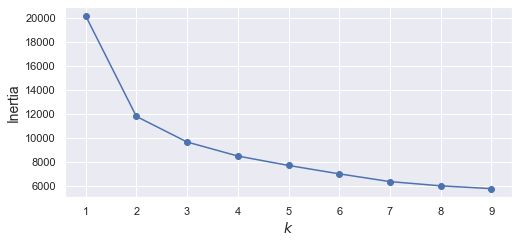

In [15]:
# inertia
kmeans_per_k = [KMeans(n_clusters=k, init='k-means++', max_iter=500, random_state=42).fit(df_scaler)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.show()

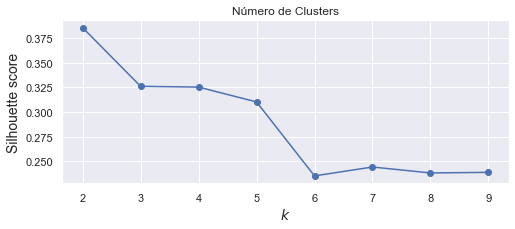

In [16]:
# silhouette
silhouette_scores = [silhouette_score(df_scaler, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.title('Número de Clusters')
plt.show()

Como de 2 para 3 cluster não muda muito no método da silhouette, vamos selecionar 3 clusters.

#### KMeans

In [17]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=500, random_state=42)
clusters = kmeans.fit_predict(df_scaler)

In [18]:
df_cl = df.copy()
df_cl['clusters'] = clusters

#### Análise dos clusters

In [19]:
df_cl['clusters'].value_counts()

0    1029
1     614
2     597
Name: clusters, dtype: int64

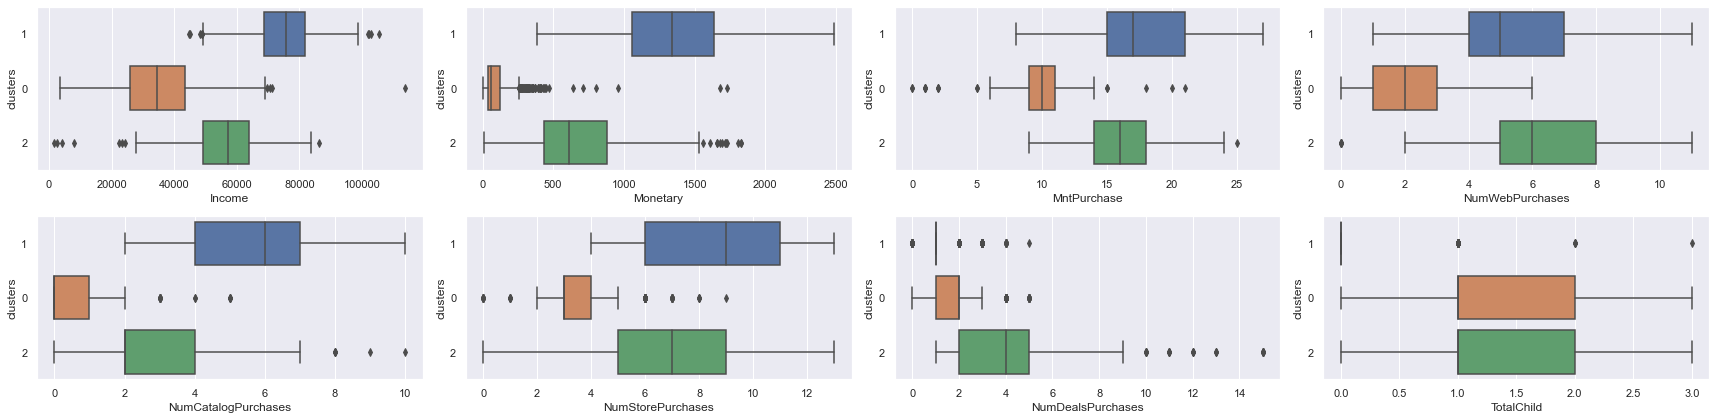

In [20]:
cols = ['ID', 'Response', 'clusters', 'MntAccepted']
cols = df_cl.drop(columns=cols).columns

df_cl['clusters'] = df_cl['clusters'].astype(str)

multi_plot(df_cl, cols, sns.boxplot, total_cols=4, y='clusters')

<AxesSubplot:xlabel='clusters', ylabel='count'>

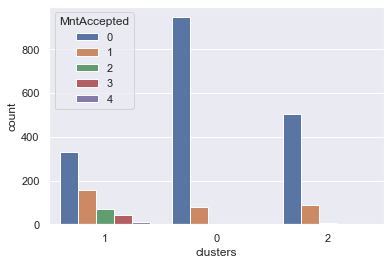

In [21]:
sns.countplot(data=df_cl, x='clusters',hue='MntAccepted')

In [22]:
df_cl.groupby('clusters').mean()

,ID,Income,Monetary,MntPurchase,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumDealsPurchases,TotalChild,MntAccepted,Response
clusters,,,,,,,,,,,
0,5612.252672,35006.298348,100.508260,10.021380,2.024295,0.551020,3.205053,1.858115,1.200194,0.083576,0.084548
1,5597.257329,75091.688925,1365.633550,17.532573,5.249186,5.710098,8.535831,1.245928,0.239414,0.778502,0.281759
2,5552.284757,56148.956449,684.556114,16.199330,6.294807,2.715243,7.422111,4.239531,1.251256,0.172529,0.123953


Grupo 0:
- É o grupo com menor renda, gastos e transações, além de não responder bem às campanhas de marketing;
- Possue 1 filho na média;
- Costumam comprar mais pela loja física.

Grupo 1:
- Possui a renda média e o valor gasto em compras superiores aos demais grupos, além disso, eles preferem, na média, realizar compras na loja física e tem a melhor aceitação às campanhas de marketing;
- A tendência desse grupo é não possuir filhos.

Grupo 2:
- Em termos de renda, gastos e transações esse é o grupo intermediário. Preferem compras online e descontos, possuem uma aceitação razoável à campanhas de marketing e, na média, possuem 1 filho.

In [23]:
df_cl_all = mkt_campaing.merge(df_cl[['ID', 'clusters']], on='ID', how='left')
df_cl_all.to_csv('ml_project1_data_clusters.csv', sep=';', index=False)

## Classificação

In [24]:
cols = ['Year_Birth', 'Kidhome', 'Teenhome', 
        'Dt_Customer', 'Z_CostContact', 'Z_Revenue',
        'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3',
        'AcceptedCmp4', 'AcceptedCmp5']
df = mkt_campaing.drop(columns=cols)

In [25]:
df.head()

,ID,Education,Marital_Status,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Response,Age,DaysCustomer,TotalChild,Monetary,MntPurchase,MntAccepted
0,5524,1,0,58138.0,58,635,88,546,172,88,88,3,8.0,10.0,4.0,7,0,1,57,760,0,1617.0,21.0,0
1,2174,1,0,46344.0,38,11,1,6,2,1,6,2,1.0,1.0,2.0,5,0,0,60,210,2,27.0,8.0,0
2,4141,1,1,71613.0,26,426,49,127,111,21,42,1,8.0,2.0,10.0,4,0,0,49,409,0,776.0,16.0,0
3,6182,1,1,26646.0,26,11,4,20,10,3,5,2,2.0,0.0,4.0,6,0,0,30,236,1,53.0,10.0,0
4,5324,4,1,58293.0,94,173,43,118,46,27,15,5,5.0,3.0,6.0,5,0,0,33,258,1,422.0,14.0,0


#### Divisão estratificada

Para que teste e treino tenha o mesmo balanceamento na variável resposta.

In [26]:
X = df.drop(columns=['Response', 'ID'])
y = df['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.33, random_state = 42)

#### Normalização

In [27]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

#### Baseline

Vamos utilizar a RandomForest como modelo base para verificar se os tratamentos seguintes que serão realizados nos dados, e outros modelos, estão performando melhor

In [28]:
crossv = StratifiedKFold(shuffle=False)
model = RandomForestClassifier(random_state=42)

score = cross_val_score(model, X_train, y_train, cv=crossv, scoring='f1')
print("Recall scores: {}".format(score))
print("Media do Recall: {}".format(score.mean()))

Recall scores: [0.4516129  0.38095238 0.29032258 0.40677966 0.47058824]
Media do Recall: 0.40005115222688314


Estamos utlizando validação cruzada com o método de estratificação porque nossa base de dados é pequena e desbalanceada,e considerando esse caso esse método permite que avaliemos melhor a performance do modelo. Como queremos identificar o maior número possível de clientes que atendam as campanhas de marketing, vamos utilizar o recall como principal método de avaliação para evitar falsos negativos.

In [29]:
model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
get_scores(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))

Acurácia:  0.895946
Precision:  0.866667
Recall:  0.354545
F1:  0.503226
[[624   6]
 [ 71  39]]


<AxesSubplot:ylabel='cols'>

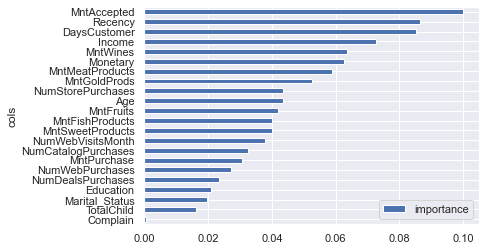

In [30]:
fi = pd.DataFrame(zip(X.columns, model.feature_importances_),
                  columns=['cols', 'importance']).set_index('cols')
fi = fi.sort_values(by='importance')
fi.plot(kind='barh')

Vamos remover as colunas Complain, por causa não possuir relevância nessa previsão e MntPurchase pra evitar multicolinearidade com as colunas Mnt...

In [31]:
X = df.drop(columns=['ID', 'Response', 'Complain', 'MntPurchase'])
y = df['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.33, random_state = 42)

scaler = StandardScaler(with_mean=True, with_std=True)
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

#### Random Forest com Oversampling

In [32]:
params = {
    'n_estimators': [100, 300, 500],
    'max_depth': [4, 8, 12, 16],
    'random_state': [42]
}

In [33]:
ros = RandomOverSampler(random_state=42)
random_overs_pipeline = make_pipeline(RandomOverSampler(random_state=42), 
                                      RandomForestClassifier(random_state=13))

new_params = {'randomforestclassifier__' + key: params[key] for key in params}
grid_over_rf = GridSearchCV(random_overs_pipeline, param_grid=new_params, cv=crossv, 
                            scoring='recall',
                            return_train_score=True)
grid_over_rf.fit(X_train, y_train)
print((grid_over_rf.best_params_,  grid_over_rf.best_score_))

score = cross_val_score(grid_over_rf, X_train, y_train, scoring='recall', cv=crossv)
print("Recall scores: {}".format(score))
print("Media do Recall: {}".format(score.mean()))

({'randomforestclassifier__max_depth': 4, 'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__random_state': 42}, 0.7098989898989899)
Recall scores: [0.72727273 0.57777778 0.73333333 0.77777778 0.68888889]
Media do Recall: 0.7010101010101011


In [34]:
y_pred = grid_over_rf.best_estimator_.named_steps['randomforestclassifier'].predict(X_test)
get_scores(y_test, y_pred)

Acurácia:  0.818919
Precision:  0.434783
Recall:  0.727273
F1:  0.544218


#### Random Forest com Pesos

In [35]:
model = RandomForestClassifier(random_state=42, class_weight='balanced')
grid_rfw = GridSearchCV(model, param_grid=params, cv=crossv, 
                               scoring='recall').fit(X_train, y_train)
print('Resultado Grid: ', grid_rfw.best_params_,  grid_rfw.best_score_)

score = cross_val_score(grid_rfw, X_train, y_train, cv=crossv, scoring='recall')
print("\nRecall scores: {}".format(score))
print("Media do Recall: {}".format(score.mean()))

Resultado Grid:  {'max_depth': 4, 'n_estimators': 500, 'random_state': 42} 0.6742424242424243

Recall scores: [0.63636364 0.6        0.68888889 0.73333333 0.62222222]
Media do Recall: 0.6561616161616162


In [36]:
y_pred = grid_rfw.predict(X_test)

get_scores(y_test, y_pred)
print('\n', confusion_matrix(y_test, y_pred))

Acurácia:  0.829730
Precision:  0.450000
Recall:  0.654545
F1:  0.533333

 [[542  88]
 [ 38  72]]


#### Regressão Logística

In [37]:
params = {
    'solver': ['lbfgs', 'liblinear'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

In [38]:
model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=500)
grid_rl = GridSearchCV(model, param_grid=params, cv=crossv, 
                       scoring='f1').fit(X_train, y_train)
print('Resultado Grid: ', grid_rl.best_params_,  grid_rl.best_score_)

score = cross_val_score(grid_rl, X_train, y_train, cv=crossv, scoring='recall')
print("Recall scores: {}".format(score))
print("Media do Recall: {}".format(score.mean()))

Resultado Grid:  {'C': 10, 'solver': 'lbfgs'} 0.5705241773221491
Recall scores: [0.79545455 0.71111111 0.77777778 0.84444444 0.86666667]
Media do Recall: 0.7990909090909091


In [39]:
y_pred = grid_rl.predict(X_test)

get_scores(y_test, y_pred)
print('\n', confusion_matrix(y_test, y_pred))

Acurácia:  0.836486
Precision:  0.468927
Recall:  0.754545
F1:  0.578397

 [[536  94]
 [ 27  83]]


(0.0, 1.0)

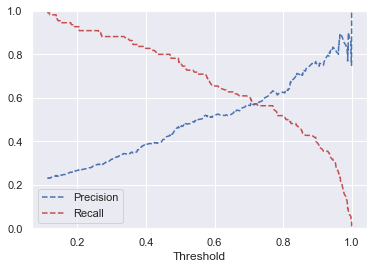

In [40]:
y_pred_prob = grid_rl.predict_proba(X_test)
precision, recall, threshold = precision_recall_curve(y_test, y_pred_prob[:,1])

plt.plot(threshold, precision[:-1], 'b--', label='Precision')
plt.plot(threshold, recall[:-1], 'r--', label='Recall')
plt.xlabel('Threshold')
plt.legend(loc='lower left')
plt.ylim([0,1])

O ponto no qual precision e recall seriam mais parecidos seria por volta 0,70. Mas, queremos o recall mais alto. Vamos apenas verificar o resultado quase o threshold fosse um pouco maior.

In [41]:
THRESHOLD = 0.57
y_pred_threshold = np.where(y_pred_prob[:, 1] > THRESHOLD, 1, 0 )

In [42]:
get_scores(y_test, y_pred_threshold)
print(confusion_matrix(y_test, y_pred_threshold))

Acurácia:  0.858108
Precision:  0.516556
Recall:  0.709091
F1:  0.597701
[[557  73]
 [ 32  78]]


Em troca de 5% de acerto no recall, ganharíamos 5% no precision, nesse conjunto de teste.

<AxesSubplot:ylabel='Feature'>

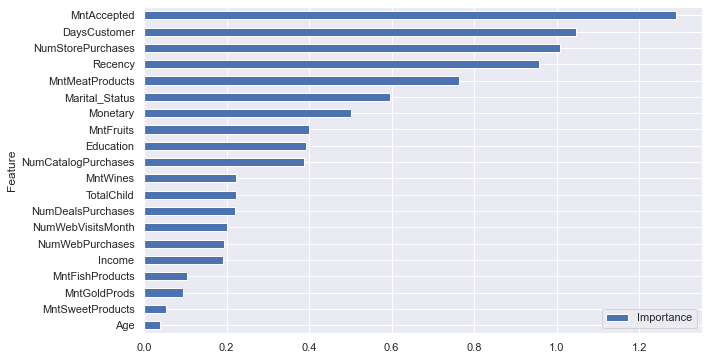

In [43]:
coefficients = grid_rl.best_estimator_.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

Dentre as alternativas validadas, a regressão logistica foi a que apresentou o melhor resultado.

#### Regressão Logística com MinMax Scaler

Vamos tentar aprimorar os resultado da regressão logística

In [44]:
cols = ['Year_Birth', 'Kidhome', 'Teenhome', 
        'Dt_Customer', 'Z_CostContact', 'Z_Revenue',
        'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3',
        'AcceptedCmp4', 'AcceptedCmp5']
df = mkt_campaing.drop(columns=cols)

In [45]:
X = df.drop(columns=['Response', 'ID'])
y = df['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.33, random_state = 42)

In [46]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [47]:
model = LogisticRegression(C=10, max_iter=1000, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

get_scores(y_test, y_pred)
print('\n', confusion_matrix(y_test, y_pred))

Acurácia:  0.858108
Precision:  0.516779
Recall:  0.700000
F1:  0.594595

 [[558  72]
 [ 33  77]]


In [48]:
dc = {
    'Acurácia': 0.858108,
    'Precision': 0.516779,
    'Recall': 0.7,
    'F1': 0.594595
}

dc = pd.DataFrame(dc, index=['values'])
dc = dc.T.reset_index(names='metrics')

<AxesSubplot:xlabel='metrics'>

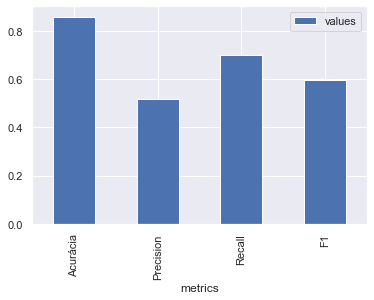

In [49]:
dc.plot(x='metrics', y='values', kind='bar')

(0.0, 1.0)

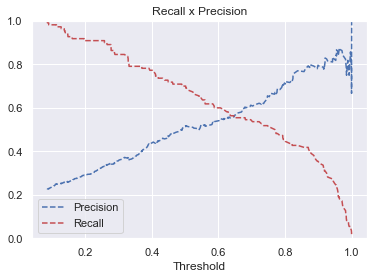

In [50]:
y_pred_prob = model.predict_proba(X_test)
precision, recall, threshold = precision_recall_curve(y_test, y_pred_prob[:,1])

plt.title('Recall x Precision')
plt.plot(threshold, precision[:-1], 'b--', label='Precision')
plt.plot(threshold, recall[:-1], 'r--', label='Recall')
plt.xlabel('Threshold')
plt.legend(loc='lower left')
plt.ylim([0,1])

In [52]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.89      0.91       630
           1       0.52      0.70      0.59       110

    accuracy                           0.86       740
   macro avg       0.73      0.79      0.75       740
weighted avg       0.88      0.86      0.87       740



In [53]:
pickle.dump(model, open('rl_mkt_model.sav', 'wb'))

#### Conclusão

Vamos utilizar a Regressão Logística aplicando pesos na variável alvo positiva, com o parâmetro C=10 conforme definido pelo hypertuning 

In [54]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.89      0.91       630
           1       0.52      0.70      0.59       110

    accuracy                           0.86       740
   macro avg       0.73      0.79      0.75       740
weighted avg       0.88      0.86      0.87       740

